In [2]:
# Importieren der Bibliotheken
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

In [3]:

# Datenabruf
url = "https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=SELECT+*+FROM+ps&format=csv"
data = pd.read_csv(url)

/tmp/ipykernel_6951/346933954.py:3: DtypeWarning: Columns (65,153,183,187,206,211) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(url)


## 2.2 Count of columns

In [10]:
len(data.columns)

354

## 3.3 Collect column

In [22]:
# Statistische Analyse der relevanten Spalten
selected_columns = ['pl_trandur', 'pl_rade', 'st_mass', 'st_teff']
stats = data[selected_columns].describe()

# Berechnung von Skewness und Kurtosis
stats.loc['skew'] = data[selected_columns].skew()
stats.loc['kurt'] = data[selected_columns].kurt()

print("Deskriptive Statistiken:\n", stats)

Deskriptive Statistiken:
          pl_trandur       pl_rade       st_mass       st_teff
count  15097.000000  15097.000000  13876.000000  15097.000000
mean       4.038955      6.018439      0.931603   5516.208764
std        2.602160     88.902818      0.220300    760.468533
min        0.133300      0.270000      0.080000   2550.000000
25%        2.333000      1.510000      0.820000   5177.000000
50%        3.355100      2.210000      0.950000   5686.000000
75%        5.005000      3.100000      1.060000   6028.000000
max       53.600000   4282.980000      3.570000  10170.000000
skew       2.562766     38.197860      0.271386     -0.803104
kurt      16.396102   1518.026434      4.916415      1.734364


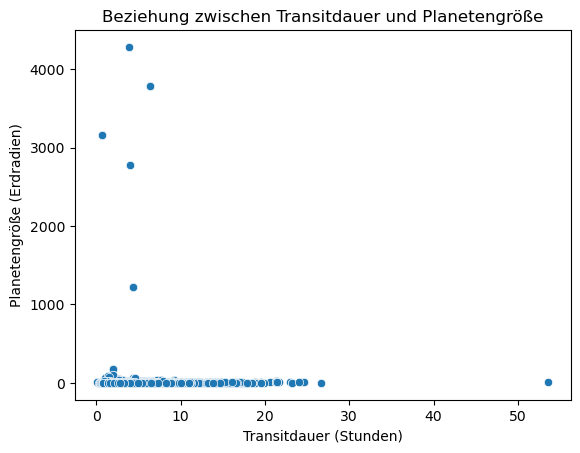

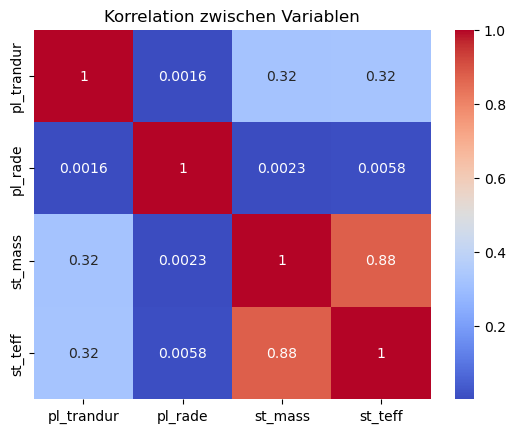

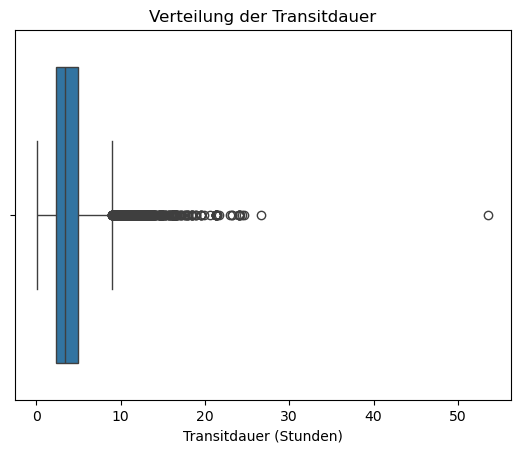

In [24]:
# Scatterplot: Transitdauer vs. Planetengröße
sns.scatterplot(x='pl_trandur', y='pl_rade', data=data)
plt.title('Beziehung zwischen Transitdauer und Planetengröße')
plt.xlabel('Transitdauer (Stunden)')
plt.ylabel('Planetengröße (Erdradien)')
plt.show()

# Heatmap: Korrelation zwischen Variablen
corr_matrix = data[selected_columns].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Korrelation zwischen Variablen')
plt.show()

# Boxplot: Transitdauer
sns.boxplot(x=data['pl_trandur'])
plt.title('Verteilung der Transitdauer')
plt.xlabel('Transitdauer (Stunden)')
plt.show()

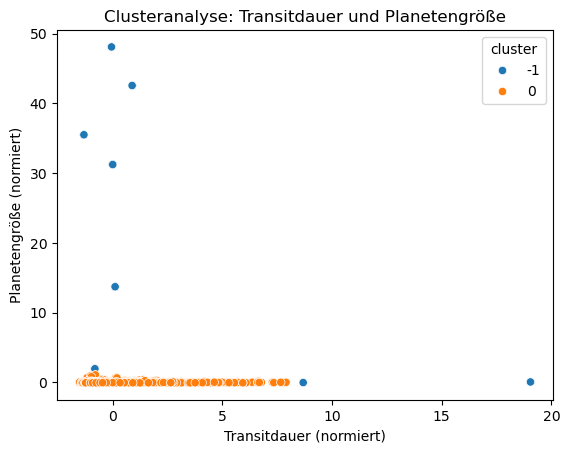

Potenzielle Ausreißer:
              pl_name  pl_trandur   pl_rade
72         WASP-76 b    3.763662    21.956
98         WASP-76 b    3.752600    20.681
103        WASP-76 b    3.800000    20.781
259     BD-14 3065 b    3.086000    21.590
271     BD-14 3065 b    2.517000    20.711
...              ...         ...       ...
35752    Kepler-29 c    4.346000  1226.400
35887  Kepler-1862 b    4.570000    63.940
35955   Kepler-167 e   16.108300     9.400
36164   Kepler-784 b   13.840000     2.240
36382    Kepler-55 c    7.891000    27.870

[298 rows x 3 columns]


In [25]:
# Clusteranalyse mit DBSCAN
from sklearn.cluster import DBSCAN

# Daten filtern und normieren
clustering_data = data[['pl_trandur', 'pl_rade']].dropna()
clustering_data = (clustering_data - clustering_data.mean()) / clustering_data.std()

# DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5).fit(clustering_data)
clustering_data['cluster'] = dbscan.labels_

# Visualisierung der Cluster
sns.scatterplot(x='pl_trandur', y='pl_rade', hue='cluster', data=clustering_data, palette='tab10')
plt.title('Clusteranalyse: Transitdauer und Planetengröße')
plt.xlabel('Transitdauer (normiert)')
plt.ylabel('Planetengröße (normiert)')
plt.show()

# Identifikation von Ausreißern
outliers = data[(data['pl_trandur'] > data['pl_trandur'].quantile(0.99)) | 
                (data['pl_rade'] > data['pl_rade'].quantile(0.99))]
print("Potenzielle Ausreißer:\n", outliers[['pl_name', 'pl_trandur', 'pl_rade']])


In [19]:
# Datenbereinigung
data = data.dropna(subset=['pl_rade', 'pl_trandep', 'st_teff'])

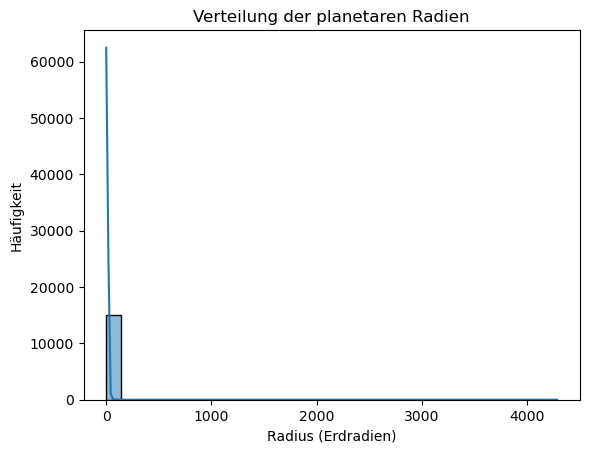

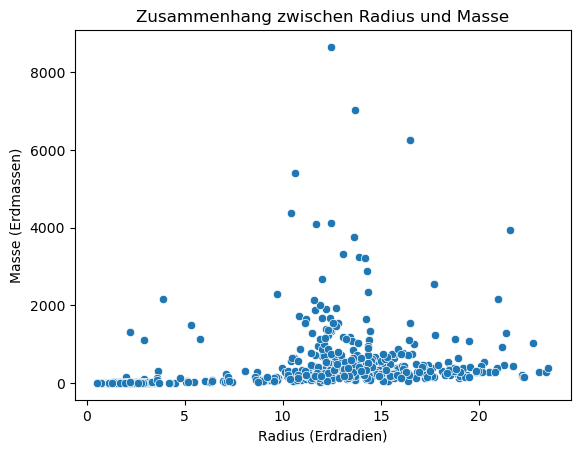

KeyError: 'pl_disposition'

In [20]:

# Feature-Erstellung
data['mass_radius_ratio'] = data['pl_bmasse'] / data['pl_rade']

# Explorative Datenanalyse
# Verteilung planetarer Radien
sns.histplot(data['pl_rade'], bins=30, kde=True)
plt.title('Verteilung der planetaren Radien')
plt.xlabel('Radius (Erdradien)')
plt.ylabel('Häufigkeit')
plt.show()

# Streudiagramm für Radius und Masse
sns.scatterplot(x='pl_rade', y='pl_bmasse', data=data)
plt.title('Zusammenhang zwischen Radius und Masse')
plt.xlabel('Radius (Erdradien)')
plt.ylabel('Masse (Erdmassen)')
plt.show()

# Modellentwicklung
X = data[['pl_rade', 'st_teff', 'pl_trandep', 'mass_radius_ratio']]
y = data['pl_disposition']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(random_state=42)
param_grid = {'n_estimators': [100, 200], 'max_depth': [10, 20]}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X_train, y_train)

# Evaluation
y_pred = grid_search.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Feature-Wichtigkeit
importances = grid_search.best_estimator_.feature_importances_
sns.barplot(x=importances, y=X.columns)
plt.title('Feature-Wichtigkeit')
plt.show()
